In [1]:
# Dependencies and models
import pandas as pd
import numpy as np
from pickle import dump

# Machine Learning Model

## Data Preprocessing

In [2]:
# Import cleaned data 
df = pd.read_csv('resources/cleaned_data.csv')
pd.set_option('display.max_columns', None)
df.head(2)

,title,rated,released,runtime,director,writer,actors,plot,language,country,awards,metascore,imdbrating,imdbvotes,dvd,boxoffice,response,genre,star,budget,gross,year,internet_movie_database_rating,rotten_tomato_rating,metacritic_rating
0,Inception,PG-13,2010-07-16,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Won 4 Oscars. 157 wins & 220 nominations total,74.0,8.8,2223702,07 Dec 2010,292576195.0,True,Action,Leonardo DiCaprio,160000000.0,836836967.0,2010,8.8,87.0,74.0
1,Iron Man 2,PG-13,2010-05-07,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Nominated for 1 Oscar. 7 wins & 44 nominations...,57.0,7.0,771885,17 Aug 2010,312433331.0,True,Action,Robert Downey Jr.,200000000.0,623933331.0,2010,7.0,72.0,57.0


In [3]:
# Replacing nulls with 'NA' and 0

df["rated"].fillna("NA", inplace = True)
df["director"].fillna("NA", inplace = True)
df["writer"].fillna("NA", inplace = True)
df["language"].fillna("NA", inplace = True)
df["country"].fillna("NA", inplace = True)
df["awards"].fillna("NA", inplace = True)
df["metascore"].fillna(0, inplace = True)
df["dvd"].fillna("NA", inplace = True)
df["boxoffice"].fillna(0, inplace = True)
df["budget"].fillna(0, inplace = True)
df["gross"].fillna(0, inplace = True)

# Check for any nulls 

df.isnull().sum()

title                             0
rated                             0
released                          0
runtime                           0
director                          0
writer                            0
actors                            0
plot                              0
language                          0
country                           0
awards                            0
metascore                         0
imdbrating                        0
imdbvotes                         0
dvd                               0
boxoffice                         0
response                          0
genre                             0
star                              0
budget                            0
gross                             0
year                              0
internet_movie_database_rating    0
rotten_tomato_rating              0
metacritic_rating                 0
dtype: int64

### Adding label column based on IMDB Rating (rating(<5): label 0,rating(>=5 and <8):label1,rating(>8):label2

In [4]:
df['label']=''
for index, row in df.iterrows():
    if (row['imdbrating']<=5):
        df.loc[index, 'label']=0
    elif (row['imdbrating']>5)&(row['imdbrating']<=8):
        df.loc[index, 'label']=1
    elif (row['imdbrating']>8):
        df.loc[index, 'label']=2

In [5]:
df['label'].value_counts()

1    1629
0      89
2      56
Name: label, dtype: int64

In [6]:
df['label'].dtype

dtype('O')

In [7]:
df['label']=pd.to_numeric(df['label'])
df['label'].fillna(0,inplace=True)
df['label']=df['label'].astype('int')

In [8]:
df['label']

0       2
1       1
2       2
3       1
4       1
       ..
1769    1
1770    0
1771    0
1772    0
1773    1
Name: label, Length: 1774, dtype: int64

### Dropping Columns not required for the model

In [9]:
df=df.drop(['title','released','awards','metascore','imdbrating' ,'imdbvotes','dvd',
           'boxoffice','response','gross', 'year','internet_movie_database_rating',
           'rotten_tomato_rating','metacritic_rating'],axis=1)                                                 
df.columns

Index(['rated', 'runtime', 'director', 'writer', 'actors', 'plot', 'language',
       'country', 'genre', 'star', 'budget', 'label'],
      dtype='object')

In [10]:
cols = ['label', 'rated', 'runtime', 'director', 'writer', 'actors','plot', 'language',
       'country', 'genre', 'star', 'budget']

In [11]:
df = df[cols]

In [12]:
df.head()

,label,rated,runtime,director,writer,actors,plot,language,country,genre,star,budget
0,2,PG-13,148,Christopher Nolan,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",A thief who steals corporate secrets through t...,"English, Japanese, French","United Kingdom, United States",Action,Leonardo DiCaprio,160000000.0
1,1,PG-13,124,Jon Favreau,"Justin Theroux, Stan Lee, Don Heck","Robert Downey Jr., Mickey Rourke, Gwyneth Paltrow",With the world now aware of his identity as Ir...,"English, French, Russian",United States,Action,Robert Downey Jr.,200000000.0
2,2,R,138,Martin Scorsese,"Laeta Kalogridis, Dennis Lehane","Leonardo DiCaprio, Emily Mortimer, Mark Ruffalo","In 1954, a U.S. Marshal investigates the disap...","English, German",United States,Mystery,Leonardo DiCaprio,80000000.0
3,1,PG-13,112,Edgar Wright,"Michael Bacall, Edgar Wright, Bryan Lee O'Malley","Michael Cera, Mary Elizabeth Winstead, Kieran ...","In a magically realistic version of Toronto, a...",English,"United States, United Kingdom, Canada, Japan",Action,Michael Cera,60000000.0
4,1,PG-13,102,Dennis Dugan,"Adam Sandler, Fred Wolf","Adam Sandler, Salma Hayek, Kevin James",After their high school basketball coach passe...,"English, Spanish",United States,Comedy,Adam Sandler,80000000.0


### Create Function for one hot encoding of writer, actors,language, country columns

In [13]:
def one_hot_encode(column,new_col_names):
    
    for index, row in df.iterrows():
        item_names=str(row[column]).split(',')
        for y in item_names:
            y=y.strip()
            if y in new_col_names:
                df.loc[index, y]=1
        

### One Hot Endcoding: Country

In [14]:
from collections import Counter
# Find most common country names
countries=df['country'].to_list()

country_list=[]

for x in countries:
    
        country_array = str(x).split(',')
        for y in country_array:
            y=y.strip()
            country_list.append(y)
most_common=Counter(country_list).most_common(10)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('country',new_col_names)

### One Hot Encoding : Language

In [15]:
languages=df['language'].to_list()

language_list=[]

for x in languages:
    
        language_array = str(x).split(',')
        for y in language_array:
            y=y.strip()
            language_list.append(y)
most_common=Counter(language_list).most_common(15)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('language',new_col_names)


### One Hot Encoding :writer

In [16]:
writers=df['writer'].to_list()

writer_list=[]

for x in writers:
    
        writer_array = str(x).split(',')
        for y in writer_array:
            y=y.strip()
            writer_list.append(y)
most_common=Counter(writer_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('writer',new_col_names)

### One Hot Encoding :actors

In [17]:
actors=df['actors'].to_list()

actor_list=[]

for x in actors:
    
        actor_array = str(x).split(',')
        for y in actor_array:
            y=y.strip()
            actor_list.append(y)
most_common=Counter(actor_list).most_common(50)
new_col_names=[]
for item in most_common:
    new_col_names.append(item[0])
    df[item[0]]=""
one_hot_encode('actors',new_col_names)



In [18]:
df=df.drop(['country','language','writer','actors'],axis=1)

In [19]:
df.columns

Index(['label', 'rated', 'runtime', 'director', 'plot', 'genre', 'star',
       'budget', 'United States', 'United Kingdom',
       ...
       'Jessica Chastain', 'Chris Evans', 'Mark Ruffalo', 'Nicolas Cage',
       'Chloë Grace Moretz', 'Johnny Depp', 'Kristen Stewart', 'Amy Adams',
       'Robert De Niro', 'Chris Pine'],
      dtype='object', length=133)

In [20]:
df.shape

(1774, 133)

In [21]:
df.head(5)

,label,rated,runtime,director,plot,genre,star,budget,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,2,PG-13,148,Christopher Nolan,A thief who steals corporate secrets through t...,Action,Leonardo DiCaprio,160000000.0,1,1,,,,,,,,,1,,1,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,PG-13,124,Jon Favreau,With the world now aware of his identity as Ir...,Action,Robert Downey Jr.,200000000.0,1,,,,,,,,,,1,,1,,1,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,R,138,Martin Scorsese,"In 1954, a U.S. Marshal investigates the disap...",Mystery,Leonardo DiCaprio,80000000.0,1,,,,,,,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,
3,1,PG-13,112,Edgar Wright,"In a magically realistic version of Toronto, a...",Action,Michael Cera,60000000.0,1,1,,1,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1,PG-13,102,Dennis Dugan,After their high school basketball coach passe...,Comedy,Adam Sandler,80000000.0,1,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [22]:
df.fillna(0,inplace=True)


In [23]:
df.isnull().sum()

label              0
rated              0
runtime            0
director           0
plot               0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 133, dtype: int64

### Reducing type of rated by merging two or more types in one

In [24]:
df.loc[df['rated']=='TV-MA', 'rated'] = 'R'
df.loc[df['rated']=='NC-17', 'rated'] = 'R'
df.loc[df['rated']=='TV-14', 'rated'] = 'PG-13'
df.loc[df['rated']=='TV-PG', 'rated'] = 'PG'
df.loc[df['rated']=='Unrated', 'rated'] = 'NA'
df.loc[df['rated']=='Not Rated', 'rated'] = 'NA'

In [25]:
df['rated'].value_counts()

R        821
PG-13    602
PG       198
NA       142
G         11
Name: rated, dtype: int64

In [26]:
stars = df.star.value_counts()

In [27]:
stars_replace = stars[stars<5].index.to_list()
for star in stars_replace:
  df['star'] =  df['star'].replace(star,'other')

df['star'].value_counts() 

other              1197
Mark Wahlberg        13
Matt Damon           12
Steve Carell         12
Liam Neeson          12
                   ... 
Paul Rudd             5
Daniel Craig          5
Charlize Theron       5
Julianne Moore        5
Chris Pratt           5
Name: star, Length: 82, dtype: int64

In [28]:
df.isnull().sum()

label              0
rated              0
runtime            0
director           0
plot               0
                  ..
Johnny Depp        0
Kristen Stewart    0
Amy Adams          0
Robert De Niro     0
Chris Pine         0
Length: 133, dtype: int64

In [29]:
df.dtypes

label               int64
rated              object
runtime             int64
director           object
plot               object
                    ...  
Johnny Depp        object
Kristen Stewart    object
Amy Adams          object
Robert De Niro     object
Chris Pine         object
Length: 133, dtype: object

In [30]:
directors=df.director.value_counts()

In [31]:
directors_replace = directors[directors<4].index.to_list()
for director in directors_replace:
      df['director'] =  df['director'].replace(director,'other_director')
df.loc[df['director']=='NA', 'director'] = 'other_director'

df['director'].value_counts() 

other_director      1452
Ridley Scott          10
Robert Schwentke       8
Clint Eastwood         7
Steven Spielberg       7
                    ... 
Justin Lin             4
Craig Gillespie        4
Jon Watts              4
John Madden            4
Kenneth Branagh        4
Name: director, Length: 71, dtype: int64

In [32]:
df_categorical=df[['rated','director','genre','star']]
df=df.drop(['rated','director','genre','star'],axis=1)

In [33]:
df

,label,runtime,plot,budget,United States,United Kingdom,France,Canada,China,Germany,Australia,Japan,India,Spain,English,Spanish,French,German,Russian,Italian,Japanese,Mandarin,Hindi,Arabic,Ukrainian,Korean,Hebrew,Swedish,Latin,Luc Besson,Nicholas Stoller,Jane Goldman,Allan Loeb,Stan Lee,Sean Anders,Brian Helgeland,Cinco Paul,Ken Daurio,Phil Hay,Sylvester Stallone,Nicholas Sparks,Woody Allen,John Morris,Matthew Vaughn,Ethan Reiff,Dan Fogelman,Matt Manfredi,Peter Straughan,Mark Bomback,Darren Lemke,Jennifer Lee,Jez Butterworth,Jonathan Aibel,Billy Ray,Evan Daugherty,Christopher Markus,Stephen McFeely,Steven Knight,Jeff Pinkner,Gary Dauberman,Christopher Nolan,Michael Bacall,Edgar Wright,Adam Sandler,Leigh Whannell,Joel Coen,Ethan Coen,Christopher McQuarrie,Simon Beaufoy,Adam McKay,Hans Christian Andersen,Chris Buck,Peter Morgan,Noah Baumbach,John-Henry Butterworth,Guillermo del Toro,Chris Morgan,Glenn Berger,Josh Appelbaum,Mark Wahlberg,Michael Fassbender,Liam Neeson,Dwayne Johnson,Steve Carell,Jennifer Lawrence,Owen Wilson,Scarlett Johansson,Matthew McConaughey,Gerard Butler,Matt Damon,Jonah Hill,Bradley Cooper,Keira Knightley,Ryan Reynolds,Emily Blunt,Channing Tatum,Chris Hemsworth,Tom Hardy,Robert Downey Jr.,Cate Blanchett,Emma Stone,Nicole Kidman,Seth Rogen,Anna Kendrick,Kevin Hart,Jesse Eisenberg,Helen Mirren,Robert Pattinson,Joel Edgerton,Rachel McAdams,Rachel Weisz,Naomi Watts,Jake Gyllenhaal,Hugh Jackman,Russell Crowe,Michelle Williams,James Franco,Anne Hathaway,Zac Efron,Jessica Chastain,Chris Evans,Mark Ruffalo,Nicolas Cage,Chloë Grace Moretz,Johnny Depp,Kristen Stewart,Amy Adams,Robert De Niro,Chris Pine
0,2,148,A thief who steals corporate secrets through t...,160000000.0,1,1,,,,,,,,,1,,1,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,124,With the world now aware of his identity as Ir...,200000000.0,1,,,,,,,,,,1,,1,,1,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,2,138,"In 1954, a U.S. Marshal investigates the disap...",80000000.0,1,,,,,,,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,
3,1,112,"In a magically realistic version of Toronto, a...",60000000.0,1,1,,1,,,,1,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,1,102,After their high school basketball coach passe...,80000000.0,1,,,,,,,,,,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1769,1,101,Serial billionaire kidnapper Logan has been sa...,0.0,,,,,1,,,,,,1,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1770,0,91,Fifteen year-old Taylor Collins is a golf lega...,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1771,0,93,The Italian mob descends on the Mexican border...,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1772,0,94,Three best friends head on a road trip into th...,0.0,1,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [34]:
df_categorical_dummies=pd.get_dummies(df_categorical)
df_categorical_dummies.shape

(1774, 174)

In [35]:
df=pd.merge(df, df_categorical_dummies, left_index=True, right_index=True)
df.shape

(1774, 303)

### Feature: plot

In [37]:
#separating plot column for processing

df_plot=df[['plot']]
df=df.drop('plot',axis=1)

In [38]:
# changing datatypes to floating for model
for col in df.columns:
    df[col]=pd.to_numeric(df[col])
    

In [39]:
df=df.fillna(0)

In [40]:
df.isnull().sum()

label                0
runtime              0
budget               0
United States        0
United Kingdom       0
                    ..
star_Vin Diesel      0
star_Will Ferrell    0
star_Will Smith      0
star_Zac Efron       0
star_other           0
Length: 302, dtype: int64

#### Plot transformation to features

In [41]:
df_plot = df_plot.replace(to_replace=',',value='', regex = True)

In [42]:
df_plot['plot'] = df_plot['plot'].str.replace(r'[^\w\s]+', '')

In [43]:
df_plot.head()

,plot
0,A thief who steals corporate secrets through t...
1,With the world now aware of his identity as Ir...
2,In 1954 a US Marshal investigates the disappea...
3,In a magically realistic version of Toronto a ...
4,After their high school basketball coach passe...


In [44]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vilaysackkhonsavanh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vilaysackkhonsavanh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vilaysackkhonsavanh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vilaysackkhonsavanh/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
stop_words=stopwords.words('english')

In [46]:
lemmatizer=WordNetLemmatizer()
i = 0
df_plot['newplot']=''
for  row in df_plot['plot']:
    word_tokens = word_tokenize(row)      
    filtered_sentence = [] 
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(lemmatizer.lemmatize(w))
    s =TreebankWordDetokenizer().detokenize(filtered_sentence)
    df_plot.at[i,'newplot']=s    
    i = i + 1

df_plot.head()

In [47]:
df_plot=df_plot.drop('plot',axis=1)

In [48]:
dataset=df_plot['newplot']
dataset

0       A thief steal corporate secret use dreamsharin...
1       With world aware identity Iron Man Tony Stark ...
2       In 1954 US Marshal investigates disappearance ...
3       In magically realistic version Toronto young m...
4       After high school basketball coach pass away f...
                              ...                        
1769    Serial billionaire kidnapper Logan savaging Ho...
1770    Fifteen yearold Taylor Collins golf legacy The...
1771    The Italian mob descends Mexican border take p...
1772    Three best friend head road trip desert one fi...
1773    Sophia unemployed academic forced change way t...
Name: newplot, Length: 1774, dtype: object

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfIdfVectorizer = TfidfVectorizer(
    stop_words='english',
    lowercase=True,
    strip_accents='ascii',
    max_features=70,
    use_idf=True,
    smooth_idf=True
  )

In [50]:
tfIdf = tfIdfVectorizer.fit_transform(dataset)
tfIdf.shape

(1774, 70)

In [51]:
# top features from dataset
top_features = pd.DataFrame(tfIdf[0].T.todense(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
top_features = top_features.sort_values('TF-IDF', ascending=False).index.tolist()

In [52]:
# saving vectorizer and top features to files

dump(tfIdf, open("tfIdf.pkl", "wb"))
dump(top_features, open("top_features.pkl", "wb"))
dump(tfIdfVectorizer, open('victorizer.pkl', 'wb'))

In [53]:
# top 70 features from dataset
print('TOP WORDS')
print(top_features)

TOP WORDS
['past', 'secret', 'team', 'agent', 'return', 'son', 'set', 'school', 'save', 'relationship', 'story', 'power', 'police', 'people', 'order', 'new', 'mysterious', 'stop', 'student', 'american', 'time', 'town', 'travel', 'true', 'try', 'turn', 'war', 'way', 'wife', 'woman', 'work', 'world', 'year', 'york', 'mother', 'mission', 'meet', 'daughter', 'event', 'earth', 'discovers', 'discover', 'death', 'day', 'couple', 'man', 'come', 'city', 'child', 'brother', 'boy', 'begin', 'fall', 'family', 'father', 'fight', 'force', 'forced', 'friend', 'girl', 'group', 'help', 'high', 'home', 'house', 'lead', 'life', 'love', 'make', 'young']


In [54]:
#print('\nDataFrame head')
df3 = pd.DataFrame((tfIdf.toarray()), columns=tfIdfVectorizer.get_feature_names())[top_features]
print(df3.head(3))

       past    secret      team  agent  return  son  set  school  save  \
0  0.616952  0.575825  0.536466    0.0     0.0  0.0  0.0     0.0   0.0   
1  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   
2  0.000000  0.000000  0.000000    0.0     0.0  0.0  0.0     0.0   0.0   

   relationship  story  power  police  people  order  new  mysterious  stop  \
0           0.0    0.0    0.0     0.0     0.0    0.0  0.0         0.0   0.0   
1           0.0    0.0    0.0     0.0     0.0    0.0  0.0         0.0   0.0   
2           0.0    0.0    0.0     0.0     0.0    0.0  0.0         0.0   0.0   

   student  american  time  town  travel  true  try  turn  war  way  wife  \
0      0.0       0.0   0.0   0.0     0.0   0.0  0.0   0.0  0.0  0.0   0.0   
1      0.0       0.0   0.0   0.0     0.0   0.0  0.0   0.0  0.0  0.0   0.0   
2      0.0       0.0   0.0   0.0     0.0   0.0  0.0   0.0  0.0  0.0   0.0   

   woman  work     world  year  york  mother  mission  meet  daughter  event 

In [55]:
df=pd.merge(df, df3, left_index=True, right_index=True)
df.shape

(1774, 372)

### Splitting Feature and Target Columns

In [56]:
# Import models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import pickle

In [57]:
X=df.drop('label',axis=1)
y=df['label']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

In [59]:
scaler=StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

### Trying RandomForest Classifier

In [60]:
model=RandomForestClassifier (random_state=1,n_estimators=500, max_depth=11,min_samples_split=5)
model.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=11, min_samples_split=5, n_estimators=500,
                       random_state=1)

In [61]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [62]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9210314262691378,testing_score:0.9136960600375235


In [63]:
# Save the model as pickle file
pickle.dump(model, open('model.pkl', 'wb'))
# Save the scaler as pickle file
pickle.dump(scaler, open('scaler.pkl', 'wb'))

### Trying SVC

In [64]:
from sklearn.svm import SVC

In [65]:
model=SVC()
model.fit(X_train_scaled,y_train)

SVC()

In [66]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [67]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9258662369057212,testing_score:0.9136960600375235


### Trying K-Nearestneighbors

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [69]:
train_scores=[]
test_scores=[]

In [70]:
for k in range (1,20,2):
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled,y_train)
    train_score=knn.score(X_train_scaled,y_train)
    test_score=knn.score(X_test_scaled,y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

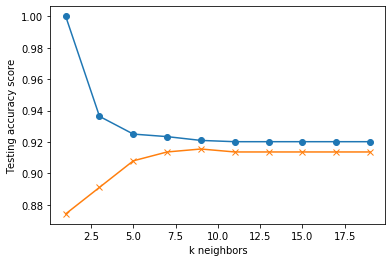

In [71]:
import matplotlib.pyplot as plt
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [72]:
knn=KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_scaled,y_train)


KNeighborsClassifier(n_neighbors=8)

In [73]:
training_score = knn.score(X_train_scaled, y_train)
testing_score = knn.score(X_test_scaled, y_test)

In [74]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:0.9250604351329573,testing_score:0.9136960600375235


### Trying other ensemble methods

In [75]:
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier

### ExtraTreesClassifier

In [76]:
model=ExtraTreesClassifier()
model.fit(X_train_scaled,y_train)

ExtraTreesClassifier()

In [77]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [78]:
print(f"training_score:{training_score},testing_score:{testing_score}")

training_score:1.0,testing_score:0.9080675422138836


### AdaBoostClassifier

In [ ]:
model=AdaBoostClassifier()
model.fit(X_train_scaled,y_train)

In [ ]:
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

In [ ]:
print(f"training_score:{training_score},testing_score:{testing_score}")